In [1]:
# Import libraries and set desired options
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm_notebook as tqdm

# 1.Data preparation

In [2]:
# Read the training and test data sets, change paths if needed
times = ['time%s' % i for i in range(1, 11)]
sites = ['site%s' % i for i in range(1, 11)]

train_df = pd.read_csv('./train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('./test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"./site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])

print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [3]:
# Create a separate dataframe where we will work with timestamps
time_df = pd.DataFrame(index=train_df.index)

time_df['target'] = train_df['target']
time_df['min'] = train_df[times].min(axis=1)
time_df['max'] = train_df[times].max(axis=1)
time_df['seconds'] = (
    (time_df['max'] - time_df['min']) / np.timedelta64(1, 's'))

In [4]:
# Index to split the training and test data sets
idx_split = train_df.shape[0]

# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

In [5]:
# Dataframe with indices of visited websites in session
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


### Reducing memory usage by csr_matrix

In [6]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(
    ([1] * sites_flatten.shape[0],
    sites_flatten,
    range(0, sites_flatten.shape[0]  + 10, 10))
)[:, 1:]

In [7]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [8]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.919524105836
CPU times: user 25.6 s, sys: 52.9 s, total: 1min 18s
Wall time: 10.3 s


In [9]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [10]:
# Train the model on the whole training data set
# Use random_state=17 for repeatability
# Parameter C=1 by default, but here we set it explicitly
lr = LogisticRegression(C=1.0, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for test data set
X_test = full_sites_sparse[idx_split:,:]
y_test = lr.predict_proba(X_test)[:, 1]

# Write it to the file which could be submitted
write_to_submission_file(y_test, 'baseline_1.csv')

# 2.Feature Engineering

In [11]:
SESSION_ID = 'session_id'
TARGET = 'target'

In [54]:
YEAR = 'year'
DAY_OF_THE_WEEK = 'day_of_the_week'
WEEK = 'week'
HOUR = 'hour'
FINISH_HOUR = 'finish_hour'
MORNING = 'morning'
START_MONTH = 'start_month'
MONTH = 'month'
UNIQUE_SITES_IN_SESSION = 'unique_sites_in_session'
SLEEPING_TIME = 'sleeping_time'

ALICE_HOUR = 'alice_hour'
ALICE_HOUR_100 = 'alice_hour_100' # more than 100
ALICE_HOUR_200 = 'alice_hour_200' # more than 100
WORKING_WEEKDAY = 'working_weekday' # increment by 1 because of 0 - Monday?
ALICE_WEEKDAY = 'alice_weekday'
ALICE_WEEKDAY_200 = 'alice_weekday_200'

In [13]:
full_df.shape, time_df.shape

((336358, 20), (253561, 4))

## Simple features

In [55]:
# Dataframe for new features
full_new_feat = pd.DataFrame(index=full_df.index)

full_new_feat[START_MONTH] = full_df['time1'].apply(
    lambda ts: 
        (ts.year) * 100 + ts.month
).astype('float64')

full_new_feat[YEAR] = full_df['time1'].apply(
    lambda ts: ts.year
).astype('int16')

full_new_feat[DAY_OF_THE_WEEK] = full_df['time1'].apply(
    lambda ts: ts.dayofweek
).astype('int8')

full_new_feat[WEEK] = full_df['time1'].apply(
    lambda ts: ts.week
).astype('int8')

full_new_feat[HOUR] = full_df['time1'].apply(
    lambda ts: ts.hour
).astype('int8')

full_new_feat[MORNING] = full_df['time1'].apply(
    lambda ts: ts.hour >= 0 and ts.hour <= 11
).astype('int8')

full_new_feat[MONTH] = full_df['time1'].apply(
    lambda ts: ts.month
).astype('int8')

full_new_feat[UNIQUE_SITES_IN_SESSION] = (
    train_df[sites].replace({0:  None}).nunique(axis=1, dropna=True))

full_new_feat[SLEEPING_TIME] =  full_df['time1'].apply(
    lambda ts: 
        ts.hour >=0 and ts.hour <= 7
).astype('int8')

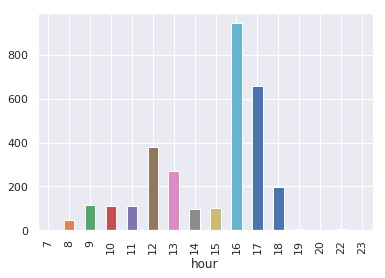

In [56]:
exam_df = (
    full_new_feat[HOUR]
    .to_frame()
    .join(time_df[TARGET].to_frame(), on='session_id')
)

grouped_by_hour = exam_df[exam_df[TARGET] == 1].groupby(HOUR).size()
grouped_by_hour_100 = grouped_by_hour[grouped_by_hour > 100]
grouped_by_hour_200 = grouped_by_hour_100[grouped_by_hour_100 > 200]

ALICE_HOURS_LIST = grouped_by_hour.index

grouped_by_hour.plot(kind='bar')

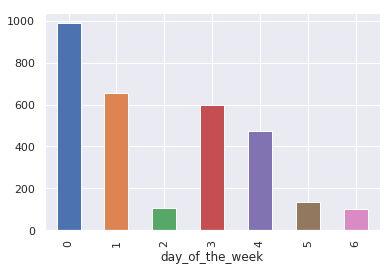

In [57]:
exam_df = (
    full_new_feat[DAY_OF_THE_WEEK]
    .to_frame()
    .join(time_df[TARGET].to_frame(), on='session_id')
)

grouped_by_weekday = exam_df[
    exam_df[TARGET] == 1].groupby(DAY_OF_THE_WEEK).size()
working_days = [range(0, 6)]
alice_weekday_200 = grouped_by_weekday[grouped_by_weekday > 200]

ALICE_WEEKDAYS_LIST = grouped_by_weekday.index

grouped_by_weekday.plot(kind='bar')

In [58]:
full_new_feat[ALICE_HOUR] = full_new_feat[HOUR].apply(
    lambda ts:
        ts in grouped_by_hour
).astype('int8')

full_new_feat[ALICE_HOUR_100] = full_new_feat[HOUR].apply(
    lambda ts:
        ts in grouped_by_hour_100
).astype('int8')

full_new_feat[ALICE_HOUR_200] = full_new_feat[HOUR].apply(
    lambda ts:
        ts in grouped_by_hour_200
).astype('int8')

full_new_feat[ALICE_WEEKDAY] = full_new_feat[DAY_OF_THE_WEEK].apply(
    lambda ts:
        ts in grouped_by_weekday
).astype('int8')

full_new_feat[ALICE_WEEKDAY_200] = full_new_feat[DAY_OF_THE_WEEK].apply(
    lambda ts:
        ts in alice_weekday_200
).astype('int8')

full_new_feat[WORKING_WEEKDAY] = full_new_feat[DAY_OF_THE_WEEK].apply(
    lambda ts:
        ts in working_days
).astype('int8')

In [59]:
full_new_feat.head().T

session_id,21669,54843,77292,114021,146670
start_month,201301.0,201301.0,201301.0,201301.0,201301.0
year,2013.0,2013.0,2013.0,2013.0,2013.0
day_of_the_week,5.0,5.0,5.0,5.0,5.0
week,2.0,2.0,2.0,2.0,2.0
hour,8.0,8.0,8.0,8.0,8.0
morning,1.0,1.0,1.0,1.0,1.0
month,1.0,1.0,1.0,1.0,1.0
unique_sites_in_session,2.0,2.0,6.0,5.0,6.0
sleeping_time,0.0,0.0,0.0,0.0,0.0
alice_hour,1.0,1.0,1.0,1.0,1.0


In [60]:
full_new_feat.shape, y_train.shape

((336358, 15), (253561,))

In [61]:
full_new_feat[TARGET] = y_train

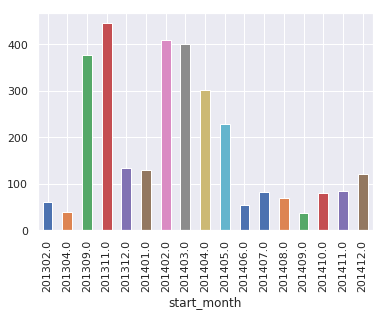

In [62]:
full_new_feat[
    full_new_feat[TARGET] == 1
].groupby(START_MONTH).size().plot(kind='bar')

In [65]:
import warnings
warnings.filterwarnings('ignore')

for feature_set in tqdm([
    [HOUR],
    [MORNING],
    [HOUR, START_MONTH],
    [START_MONTH, HOUR],
    [MORNING, START_MONTH],
    [START_MONTH, MORNING, HOUR]
]):
    tmp = StandardScaler().fit_transform(full_new_feat[feature_set])
    X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

    # Compute metric on the validation set
    score = get_auc_lr_valid(X_train, y_train)
    
    print(f'Score: {score}, Features: {feature_set}')

Score: 0.9565883156046355, Features: ['hour']
Score: 0.947403479438092, Features: ['morning']
Score: 0.9579249120811173, Features: ['hour', 'start_month']
Score: 0.957924610161877, Features: ['start_month', 'hour']
Score: 0.9487757023849204, Features: ['morning', 'start_month']
Score: 0.9591528176311174, Features: ['start_month', 'morning', 'hour']



In [66]:
features = list(full_new_feat.columns)

results = []

for feature_set in tqdm(features):
    tmp = StandardScaler().fit_transform(full_new_feat[[feature_set]])
    X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

    # Compute metric on the validation set
    score = get_auc_lr_valid(X_train, y_train)
    
    results.append((score, feature_set))
    
#     print(f'Score: {score}, Features: {feature_set}')

In [67]:
sorted_res = results.sort(key=lambda result: result[0], reverse=True)

results

[(1.0, 'target'),
 (0.95658831560463553, 'hour'),
 (0.95349462462984702, 'alice_hour_200'),
 (0.947403479438092, 'morning'),
 (0.93679547145293207, 'alice_hour_100'),
 (0.93656012540517564, 'day_of_the_week'),
 (0.93396226130264881, 'alice_weekday_200'),
 (0.91969861515682894, 'start_month'),
 (0.91961936135626954, 'year'),
 (0.91959830248926377, 'sleeping_time'),
 (0.91958811271490615, 'alice_hour'),
 (0.91952440775521849, 'alice_weekday'),
 (0.91952440775521849, 'working_weekday'),
 (0.91896872539358188, 'month'),
 (0.91847282304151023, 'week'),
 (0.91617755749750018, 'unique_sites_in_session')]

In [73]:
FEATURE_SET = [
    HOUR, 
    ALICE_HOUR_200, 
    MORNING, 
    DAY_OF_THE_WEEK, 
    START_MONTH, 
    SLEEPING_TIME
]

tmp = StandardScaler().fit_transform(full_new_feat[FEATURE_SET])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], tmp[:idx_split,:]]))

score_C_1 = get_auc_lr_valid(X_train, y_train)

# Compute metric on the validation set
Cs = np.logspace(-2, 0, 15)
scores = []
for C in tqdm(Cs):
    scores.append(get_auc_lr_valid(X_train, y_train, C=C))

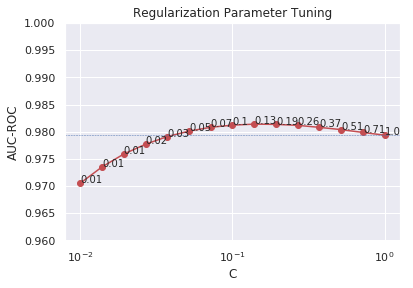

In [75]:
plt.plot(Cs, scores, 'ro-')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('AUC-ROC')
plt.title('Regularization Parameter Tuning')
# horizontal line -- model quality with default C value
plt.axhline(y=score_C_1, linewidth=.5, color='b', linestyle='dashed') 

MINIMAL_THRESHOLD = 0.96

axes = plt.gca()
axes.set_ylim([MINIMAL_THRESHOLD, 1])

list_of_results = [
    (C, score) 
    for C, score in list(zip(Cs, scores)) 
    if score >= MINIMAL_THRESHOLD
]

for C, score in list_of_results: 
    plt.text(C, score, str(C)[:4])

plt.show()

In [87]:
list_of_results.sort(
    key=lambda score_pair: score_pair[1], 
    reverse=True)

max_C = list_of_results[0][0]

max_C

0.13894954943731375

In [89]:
# Prepare the training and test data
C=max_C

tmp_scaled = StandardScaler().fit_transform(full_new_feat[FEATURE_SET])
X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                             tmp_scaled[:idx_split,:]]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                            tmp_scaled[idx_split:,:]]))

# Train the model on the whole training data set using optimal regularization parameter
lr = LogisticRegression(C=C, random_state=17, solver='liblinear').fit(X_train, y_train)

# Make a prediction for the test set
y_test = lr.predict_proba(X_test)[:, 1]


# Write it to the submission file
write_to_submission_file(y_test, 'baseline_2.csv')